In [1]:
import sympy as sym
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64",True)
from sympy import factorial
from sympy.plotting import plot
from sympy.series.series import series
import matplotlib.pyplot as plt
plt.style.use('ggplot')

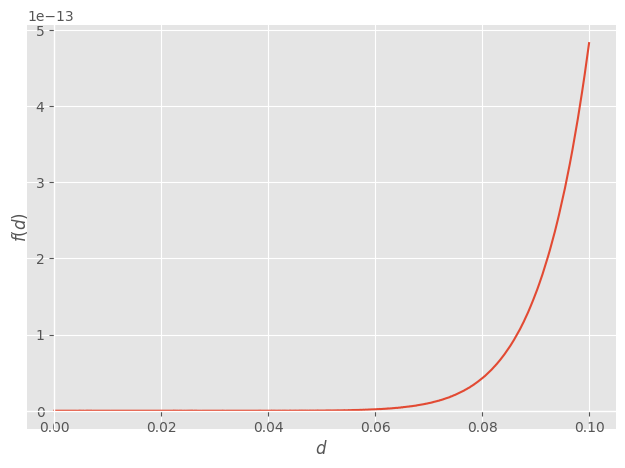

In [2]:
p = 5
exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [factorial(p + i) / (factorial(i) * factorial(p - i)) * (sym.sqrt(8 * p + 4))**(p - i) for i in range(p + 1)]
powers = list(range(p,-1,-1))
norm_cons = factorial(p)/factorial(2*p)


d = sym.symbols('d')
matern = norm_cons*sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)

S = series(sym.log(matern),d,0,2*p+1).removeO()

plot(matern - sym.exp(S),(d,0,0.1))

In [3]:


polyS = sym.Poly(S,d)

coeffs = polyS.all_coeffs()
powers = polyS.monoms()

In [4]:
list(map(lambda x:x[0],powers))

[10, 8, 6, 4, 2]

In [5]:
p = 2
exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [factorial(p + i) / (factorial(i) * factorial(p - i)) * (sym.sqrt(8 * p + 4))**(p - i) for i in range(p + 1)]
powers = list(range(p,-1,-1))
norm_cons = factorial(p)/factorial(2*p)

d = sym.symbols('d')
matern = norm_cons*sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)



S = series(sym.log(matern),d,0,2*p+1).removeO()
polyS = sym.Poly(S,d)
asy_coeffs = polyS.coeffs()
asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

asy_powers = polyS.monoms()
half_asy_powers = jnp.array(asy_powers)[:,0]//2

In [6]:
asy_coeffs

Array([ 0.69444444, -0.83333333], dtype=float64)

In [7]:
half_asy_powers

Array([2, 1], dtype=int64)

In [26]:
def setup_matern(p):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)
    S = series(sym.log(matern),d,0,2*p+1).removeO()
    polyS = sym.Poly(S,d)
    asy_coeffs = polyS.coeffs()
    asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

    asy_powers = polyS.monoms()
    half_asy_powers = jnp.array(asy_powers)[:,0]//2

    def matern_p_factory(rho):
        def matern_func(x,y):
            d2 = jnp.sum((x-y)**2)/(rho**2)
            d = jnp.sqrt(d2)
            true = jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
            asymptotic = jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
            return jnp.where(d2<1e-5, asymptotic, true)
        return matern_func
    
    return matern_p_factory

In [9]:
from KernelTools import vectorize_kfunc,make_block,dxx_k
import matplotlib.pyplot as plt

k = setup_matern(3)(1.)

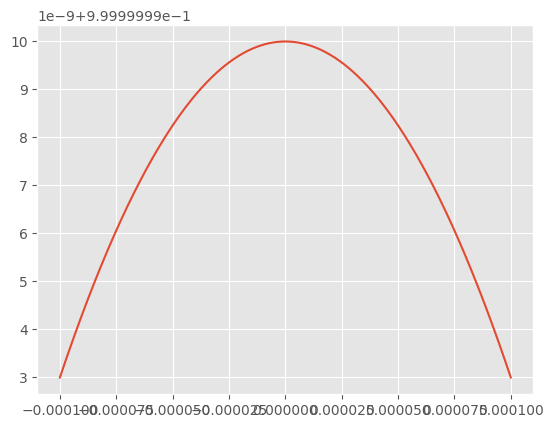

In [10]:
grid = jnp.linspace(-0.0001,0.0001,1000)
values = vectorize_kfunc(k)(jnp.array([0.]),grid)[0]
plt.plot(grid,values)

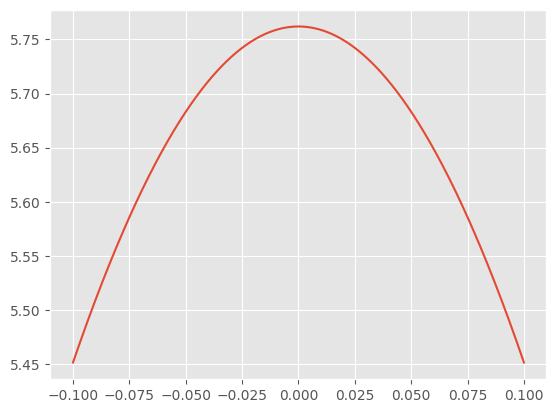

In [30]:
k_modified = setup_matern(5)(1.)

vkphi = vectorize_kfunc(dxx_k(dxx_k(k_modified,0),1))
n = 500
zero = jnp.array([[0,0.]])

bound = 0.1
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-bound,bound,n)]).T

values = vkphi(zero,grid)[0]
plt.plot(grid[:,1],values)

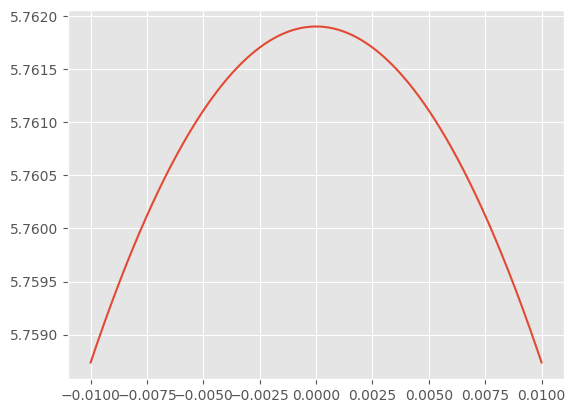

In [13]:
from Kernels import get_matern
k_original = get_matern(5,1.)

# vkphi = vectorize_kfunc(dxx_k(dxx_k(k_original,0),1))
# vkphi = make_block(k_original,dxx_k,dxx_k)

vkphi = vectorize_kfunc(dxx_k(dxx_k(k_original,0),1))


n = 500
bound = 0.01
zero = jnp.array([[0,0.]])
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-bound,bound,n)]).T

values = vkphi(zero,grid)[0]
plt.plot(grid[:,1],values)

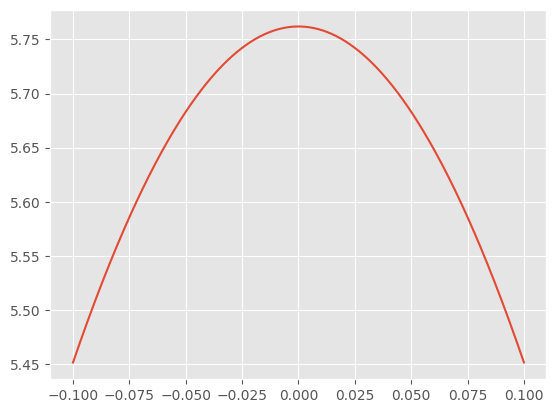

In [14]:
k = get_matern(5,1.)


vkphi = vectorize_kfunc(dxx_k(dxx_k(k,0),1))
n = 500
zero = jnp.array([[0,0.]])
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-0.1,.1,n)]).T
plt.plot(grid[:,1],make_block(k,dxx_k,dxx_k)(zero,grid)[0])

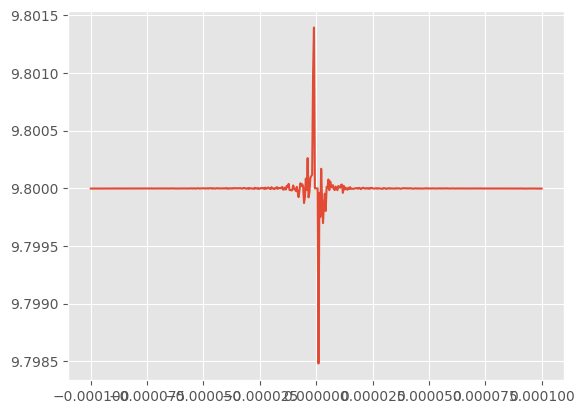

In [24]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_matern
)

k = get_matern(3,1.)


vkphi = vectorize_kfunc(dxx_k(dxx_k(k,0),1))

bound = 0.0001
zero = jnp.array([[0,0.]])
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-bound,bound,n)]).T
plt.plot(grid[:,1],make_block(k,dxx_k,dxx_k)(zero,grid)[0])


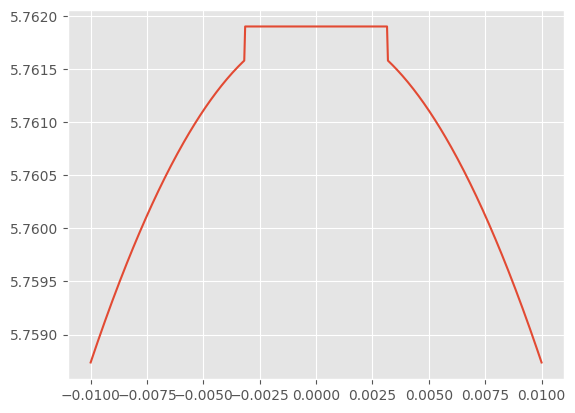

In [33]:
from KernelTools import vectorize_kfunc,dxx_k,make_block
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_matern
)
from Kernels import get_gaussianRBF

import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.special import factorial

def get_matern(p,rho):
    """
        Builds a Matern kernel function.

        Args:
            p (int): As used in smoothness nu = p + 1/2.
            rho (double): Length scale of the Matern kernel.

        Returns:
            function: This function returns the Matern kernel with smoothness p+1/2 and lengthscale rho.   
    """
    exp_multiplier = -jnp.sqrt(2 * p + 1)
    coefficients = jnp.array([factorial(p + i) / (factorial(i) * factorial(p - i)) * (jnp.sqrt(8 * p + 4))**(p - i) for i in range(p + 1)])
    powers = jnp.arange(p,-1,-1)
    norm_cons = factorial(p)/factorial(2*p)
    def k(x,y):
        # True 
        d2 = jnp.sum((x-y)**2)/rho**2
        d = jnp.sqrt(d2+1e-100)
        true =  norm_cons*jnp.sum(coefficients * jnp.power(d,powers))*jnp.exp(exp_multiplier * d)
        #  Taylor
        nu = p + 1/2
        taylor = 1 + (nu/(2*(1-nu))*d2 + nu**2/(8*(2-3*nu+nu**2))*(d2)**2)
        return jnp.where(d2<1e-5, taylor, true)
    return k


k = get_matern(5,1.)


vkphi = vectorize_kfunc(dxx_k(dxx_k(k,0),1))
n = 500
zero = jnp.array([[0,0.]])
bound = 1e-2
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-bound,bound,n)]).T
plt.plot(grid[:,1],make_block(k,dxx_k,dxx_k)(zero,grid)[0])